# MLVC Exercise 2

This notebook contains the second exercise of the Machine Learning for Visual Computing (193.189) lecture at TU Wien. Assignment via TUWEL. Please be aware of the deadlines in TUWEL.

* Upload a zip-file with the required programms. The programming language is python.
    1. Linear Regression --> `solutions/linear_regression.py`
    2. Support Vector Regression --> `solutions/svr.py`
    3. Gaussian Process --> `solutions/gp.py`
* If you needed additional conda or pip packages add an anaconda environment.yml to the zip-file
    1. conda env export > environment.yml
    2. See --> https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment

### Conda instructions

1. conda create --name MLVC python=3.11
2. conda activate MLVC
3. Install the correct version of pytorch:
    - CPU: python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
    - GPU: python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129
4. python -m pip install pillow matplotlib tqdm torchinfo pandas ipykernel nbformat ipywidgets scikit-learn tabulate seaborn umap-learn cvxopt
5. Add python kernel to Jupyter Notebooks
    - python -m ipykernel install --user --name MLVC --display-name "Python (mlvc)”

### Note 1: You may reuse the conda environments for all exercises!
### Note 2: You may also use different package managers (e.g. pip, mamba, ...)!
### Note 3: You do not need to exactly match the expected results: similar performance is sufficient.


### **Please update your group number in the filename (_X) and only upload your solutions folder.**

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
from tabulate import tabulate
import seaborn as sns
import json
import random
import torch
from collections import OrderedDict
import umap

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from utils import pick_device, print_device_info
from utils import plot_regression_over_time

np.set_printoptions(suppress=True)

# General setting for the ipynb
NUM_SAMPLES = 10000  # Number of training samples that will be generated, do not exceed 25.000 on the TUWEL Jupyter Notebooks (will crash kernel)
TEST_RATIO = 0.9  # Percentage of the generated samples that are used for training (rest is used for testing). [0, 1]

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = pick_device()
print_device_info(device)

Using CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU (capability 8.9)


## Generate and Prepare Data

In [1]:
from utils import simulate_pendulum_dataset, plot_pendulum_dataset

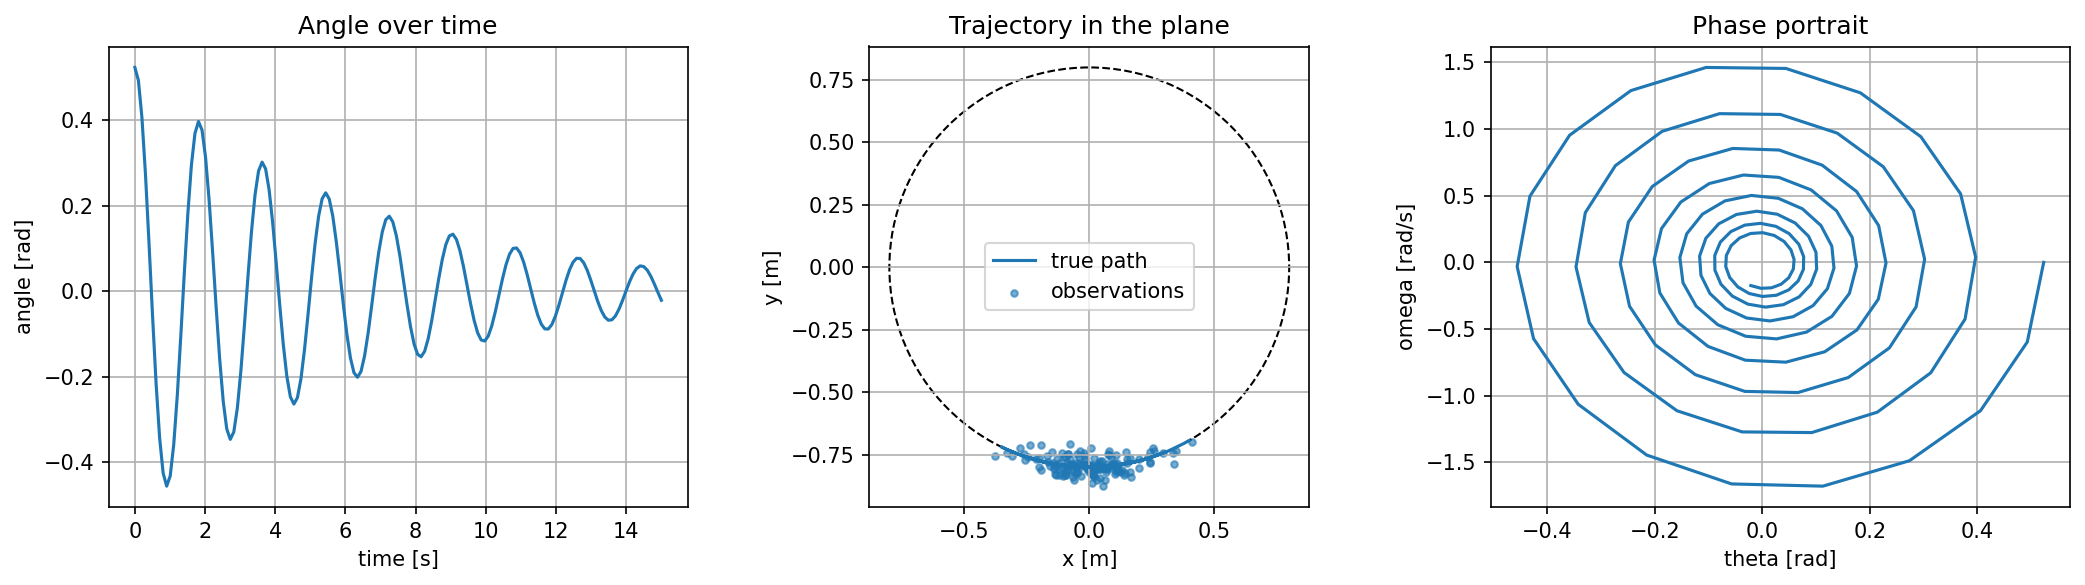

In [3]:
pendulum_dataset = simulate_pendulum_dataset(
    num_samples=150,
    t_max=15.0,
    length=0.8,
    gravity=9.81,
    damping=0.3,
    theta0=np.deg2rad(30),
    omega0=0.0,
    noise_std=0.03,
    seed=42,
)

plot_pendulum_dataset(pendulum_dataset, length=0.8, show_phase=True)

# Full index array
idx_all = np.arange(len(pendulum_dataset))

# Split index (e.g., first 60% for training)
split_idx = int(0.6 * len(pendulum_dataset))

# Training = first 60%
idx_train = idx_all[:split_idx]

# Validation = last 40%
idx_val = idx_all[split_idx:]

# Extract subsets
X = pendulum_dataset[["t"]].values              # use time as input
y = pendulum_dataset["theta"].values            # target = true angle

X_train, y_train = X[idx_train], y[idx_train]
X_val = np.arange(0, 15.0, 0.1).reshape(-1, 1)  # dense validation set



## 1. Bayesian Linear Regression (10 Points)

The following code works only, if corresponding definitions in the 'solutions' folder are complete. Look at the 'ToDo' comments in the corresponding files.

In [ ]:
from solutions.linear_regression import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_val_pred_lr = lr.predict(X_val)

In [ ]:
plot_regression_over_time(pendulum_dataset, idx_train, X_val, y_val_pred_lr, y_val_std=None, title="Linear Regression")

#### Linear Regression Expected Results

- Learns a single global linear mapping.
- Has no flexibility to capture periodic or curved trends

    → Predicts a straight line, misses all oscillations

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/regression_lr.png" style="height:100%; width:auto;">
  </div>
</div>

## 2. Support Vector Regression (10 Points)

The following code works only, if corresponding definitions in the 'solutions' folder are complete. Look at the 'ToDo' comments in the corresponding files.

In [ ]:
from solutions.svr import EpsilonSVR
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern, DotProduct, WhiteKernel

In [ ]:
kernel = RBF(length_scale=1)

svr = EpsilonSVR(C=5.0, epsilon=1e-5, kernel=kernel)
svr.fit(X_train, y_train)
y_val_pred_svr = svr.predict(X_val)

plot_regression_over_time(pendulum_dataset, idx_train, X_val, y_val_pred_svr, y_val_std=None, title="Support Vector Regression")

In [ ]:
kernel = ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1)


svr = EpsilonSVR(C=5.0, epsilon=1e-5, kernel=kernel, normalize=False)
svr.fit(X_train, y_train)
y_val_pred_svr = svr.predict(X_val)

plot_regression_over_time(pendulum_dataset, idx_train, X_val, y_val_pred_svr, y_val_std=None, title="Support Vector Regression")

#### Support Vector Regression Expected Results

- With a linear kernel, behaves like linear regression.
- With a non-linear kernel (like RBF), can fit periodic and curved data
- Robust to noise due to margin formulation

    → Captures the sinusoidal nature, though kernel parameter tuning required and no confidence intervals

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/regression_svr.png" style="height:100%; width:auto;">
  </div>
</div>

## 3. Gaussian Process (10 Points)

The following code works only, if corresponding definitions in the 'solutions' folder are complete. Look at the 'ToDo' comments in the corresponding files.

In [ ]:
from solutions.gp import GaussianProcess
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern, DotProduct, WhiteKernel

In [ ]:
kernel = RBF(length_scale=1)

gp = GaussianProcess(kernel=kernel)
gp.fit(X_train, y_train)
y_val_pred_gp, y_val_std_gp = gp.predict(X_val)

plot_regression_over_time(pendulum_dataset, idx_train, X_val, y_val_pred_gp, y_val_std=y_val_std_gp, title="Gaussian Process")

In [ ]:
kernel = ExpSineSquared(length_scale=1, periodicity=1) + RBF(length_scale=1)

gp = GaussianProcess(kernel=kernel)
gp.fit(X_train, y_train)
y_val_pred_gp, y_val_std_gp = gp.predict(X_val)

plot_regression_over_time(pendulum_dataset, idx_train, X_val, y_val_pred_gp, y_val_std=y_val_std_gp, title="Gaussian Process")

#### Gaussian Process Expected Results

- Non-parametric, kernel-based Bayesian approach
- Fits smooth functions with uncertainty estimates

    → Gives the best fit and provide confidence intervals that widen where data is sparse.

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/regression_gp.png" style="height:100%; width:auto;">
  </div>
</div>